In [1]:
import pandas as pd
import re
import pytz
import pandas as pd
from collections import Counter


In [2]:
# Read the list of filenames from the configuration file
with open('../file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = f"../data/{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1



In [3]:
# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])
data['date'] = pd.to_datetime(data['date'])



In [4]:
def convert_utc_to_cet(df, date_column='date'):
    
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure timestamps are UTC aware
    if df[date_column].dt.tz is None:
        df[date_column] = df[date_column].dt.tz_localize('UTC')
    elif df[date_column].dt.tz != pytz.UTC:
        df[date_column] = df[date_column].dt.tz_convert('UTC')
    
    # Convert to CET/CEST (Europe/Berlin includes proper DST handling)
    df[date_column] = df[date_column].dt.tz_convert('Europe/Berlin')
    
    return df

data = convert_utc_to_cet(data)

In [5]:
seventvlis = ['arnoldHalt',
 'SEXO',
 'peepoMarch',
 'doroHEAD',
 '4stars',
 'Rizzler',
 'ppL',
 'WAIT',
 'SpeedLaugh',
 'GetALoadOfThisGuy',
 'ModAbuse',
 'DoroCheer',
 'BHOP',
 'WhoAsked',
 'SCRAPETHATSHITJOHNNY',
 'OverwhelminglyWholesome',
 'SAJ',
 'NOW',
 'LETSFUCKINGJOE',
 '3stars',
 'aga',
 'ome47',
 'OMEGALUL',
 'Gayge',
 'peepoFat',
 'HolyFuck',
 'RAHH',
 'SNIFFA',
 'xdd',
 'EDGE',
 'LetsBingo',
 '!lurk',
 'Caught',
 'monakS',
 'ahmadmuhsin',
 'wade',
 'parasocial',
 'EdwardStare',
 'ISeeYou',
 'YouWouldntGetIt',
 'Banties',
 'DRAIN',
 'banties',
 'PepeHands',
 'WidelebronJAM',
 'Lamonting',
 'CAUGHT',
 'LOL',
 'FeelsDankMan',
 'pepeJAM',
 'ayo',
 '!unfollow',
 'glorp',
 'Waiting',
 'owoshy',
 'wideduckass',
 'HELLO',
 'Pepega',
 'DeathIncoming',
 'brbToilet',
 'ads',
 'despair',
 'TWEAK',
 'sus',
 'THINKING',
 'bruv',
 'ROFL',
 'juh',
 'skip',
 'OuttaPocket',
 'RareParrot',
 'emergencylandingstrip',
 'FirstTimePepega',
 'WideCatGroove',
 'Clueless',
 'ADHD',
 'StoryTime',
 'Delusional',
 'firewriting',
 'ragebait',
 'Aloo',
 'ome15',
 'peepoHug',
 'PagMan',
 'Based',
 'OMFG',
 'PepegaAim',
 'VeryPog',
 'OVERWORKING',
 'LL',
 'myIQ',
 'doroFiddy',
 'MUGA',
 'SAVEME',
 'GotEEM',
 'PagChomp',
 'Surfing',
 'PokiShare',
 'FEINFEINFEINFEINFEINFEINFEINFEI',
 'FeelsLagMan',
 'flowerr',
 'speed1',
 'NAUR',
 'BINGO',
 'STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE',
 'gothKiss',
 'WAYTOODANK',
 'ppOverheat',
 'ManchesterUnited',
 'dogJAM',
 'ewphop',
 'fortnite',
 'Doc1v1',
 'GotCaughtTrolling',
 'nonono',
 'dash',
 'veryDoro',
 'YAPPING',
 '!boost',
 'Bleh',
 'Sadge',
 'GIGAMOD',
 'dudWhat',
 'gPls',
 'YANITED',
 'Alarm',
 'WHOAAA',
 'HOLY',
 'TheVoices',
 'PokiShareW',
 'SpeedR',
 'RoxyPotato',
 'STREAMER',
 'emo2',
 'WatchingStream',
 'POVbornbefore2000',
 'lemon',
 'RaveTime',
 'dome44',
 'shutup',
 'ome55',
 'gg',
 'typeshit',
 'peepoLeave',
 'Paul',
 'unibrow',
 'GRRR',
 'lebronArrive',
 'DoroTalkingAgain',
 'ome29',
 'CrayonTime',
 'ANOTHERONE',
 'saythatagain',
 'monkaW',
 'peepoHey',
 'ONEMORE',
 'Considering',
 'Explosion',
 'LULE',
 'peepoKiss',
 'Joel',
 'CLOWNDETECTED',
 'ChillGuy',
 'Exerpas',
 'walterShocked',
 'ohneFinger',
 'SteerR',
 'lebronJAM',
 '+1',
 'EZdodge',
 'CLEAN',
 'ogo',
 'yesbro',
 'BantiesPaulBeef',
 'WalterVibe',
 'SOYSCREAM',
 'Pffttt',
 'WW',
 'VeryKey',
 'ome14',
 'spongePls',
 'Bello',
 'bieberDougie',
 'MODDING',
 ':tf:',
 'heyywithrizz',
 'HowDoWeTellHer',
 'sdd',
 'plinkVibe',
 'omeClap',
 'xJAM',
 'RussiaPls',
 'DRAMA',
 'firsttimebuh',
 'AINTNOWAY',
 'BUSSIN',
 'TriJam',
 'Modding',
 'WePaid',
 'Loading',
 'wideSpeedLaugh3',
 'ome104',
 'goblin44',
 'CaughtIn4K',
 'omEE',
 '0pixel',
 'arthur',
 'xqcL',
 'Borfday',
 'jacob3',
 '4Weird',
 'bah',
 'RealForsen',
 'BOOBA',
 'doroMAD',
 '5Head',
 'xqcTwerk',
 'Ohh',
 'peepoDJ',
 'HeDisconnected',
 'SCHEISSE',
 'scawy',
 'hi',
 'Drake',
 'RIPBOZO',
 'GAMBA',
 'RightThere',
 'JermaSoy',
 'wig',
 'WHOLETHERSLAY',
 'RAGEY',
 'peepoShy',
 'AIWITHTHEBRAIDS',
 'lurkk',
 'PepegaChat',
 'YeahThatsWhatIWouldaDid',
 'catDespair',
 'FellOff',
 'WIDEALERT',
 'Plotge',
 'mods',
 'Parasocial',
 'WakeTheFuckUpSamuraiWeHaveACityToBurn',
 'brb',
 'hackingCD',
 'luton',
 'heh',
 'BELIEVERS',
 'mhm',
 'Flirt',
 'PTSD',
 'LieMeter',
 'THIS',
 'uuh',
 'doroGHOST',
 'niceguy',
 'TriSad',
 'catSigh',
 'RememberTheDays',
 'OLDWORK',
 '(7TV)',
 'LookUp',
 'weirdChamp',
 'peepoTalk',
 'helvete',
 'EDITING',
 'OVERWATCH',
 'JESSE',
 'amongE',
 'COMEHERE',
 'MeRN',
 'emo',
 'Chatting',
 'goaler',
 'catJAM',
 'biteof87',
 'winton',
 'Looking',
 'om',
 'TRUEING',
 'peepoHappy',
 'VIDEOGAME',
 'justinbieber',
 'pickle',
 'SurE',
 'SLAY',
 'YAAY',
 'merch',
 'unmod',
 'GULP',
 'reckH',
 '5stars',
 'NoMaidens',
 'pepeW',
 'Sippin',
 'totallylistening',
 'WaitingForLove',
 'BANGER',
 'D:',
 'Dave',
 'WAHHH',
 'PepegaReading',
 'Steve',
 'forsenPls',
 'dome32',
 'OMEYES',
 'Jammies',
 'Listening',
 'GlorpMeeting',
 'glorprave',
 ':33',
 'BatChestAbove',
 'sisyphus',
 'BORGIR',
 'peepoPride',
 'NOIDONTTHINKSO',
 'INTENSEGAMING',
 '!drop',
 'lore',
 'NAHHHH',
 'phpk',
 'ImtiredBoss',
 'oopsie',
 'ok',
 'MAJ',
 'KKalinka',
 'FeelsWeirdMan',
 'NAvsEU',
 'ome101',
 '3Heading',
 'vibePls',
 'GoodTake',
 'ome105',
 'Yooo',
 'ome99',
 'omeStare',
 'LastTimeChatter',
 'Cinema',
 'HARAM',
 'Devious',
 'WideRaveTime',
 'Yoink',
 'AAAAAAAAUHGGH',
 'StreamEnding',
 'Johnporkiscalling',
 'SCHIZO',
 'FirstTimeChatter',
 'Waddup',
 'catBusiness',
 'modCheck',
 'FeelsStrongMan',
 'CatTime',
 'PianoTime',
 'FLASHBANG',
 'OOOO',
 'Susge',
 'nuhuh',
 'SUSSY',
 'NAILSING',
 'classic',
 'deadassFaint',
 'chatters',
 'ome44',
 'HABIBI',
 'ryanArrive',
 'joever',
 'Cuck',
 'pepeGun',
 'midloud',
 'LOCKIN',
 'ome32',
 'FARMING',
 'Scared',
 'matSad',
 'BEGGING',
 'GotCaughtCheating',
 'poroPls',
 'PepePls',
 'Sits',
 'sotruebestie',
 'Tuckge',
 'onggang',
 'widetime',
 'vas',
 'OneGuy',
 'HELP',
 'gkeywide',
 'life',
 'freddy',
 'GoodBye',
 'ome69',
 'AAAA',
 'AURA',
 'omeJudging',
 'doggoSlava',
 'GIGACHAIR',
 'pKitten',
 'SADge',
 'MYLIFE',
 'YouGotMe',
 'buhFlipExplode',
 'peepoSmile',
 'ome18',
 'glorpdetective',
 'Flushed',
 'Reacting',
 'peepoSad',
 'agahi',
 'AlienPls',
 'MODS',
 'characterSelected',
 'PotFriendDance',
 'Hmm',
 'MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse',
 'FUNNY',
 'Barry63',
 'forsenCD',
 'SpeedL',
 'Jay',
 'GOONING',
 'gkitten',
 'omeJAM',
 'FeelsLateMan',
 'wot',
 'bog',
 'WideHUH',
 '1star',
 'MeWhenIBuyEgyptianProperty',
 'xqc32',
 'smh',
 'Pipege',
 'SERIOUSLY',
 ':3',
 'doroKick',
 'peepoRiot',
 'Whenyourinnerwolfreleases',
 'nanaAYAYA',
 'catSmash',
 'catKISS',
 'RIRI',
 'SCORN',
 'IMGOINGINSANEANDCOMPLETELYLOSINGITAAAAAAAAAAAHHHHHHH',
 'happi',
 'KEKW',
 'jacob2',
 'NAHH',
 'NOCHECKMARKS',
 'YESS',
 'buh',
 'EZ',
 'POLICE',
 'BaileyChamp',
 'peepoDoubters',
 'WeDoNotCare',
 'cokeBreak',
 'peepoComfy',
 'doroJAM',
 'ReallyMad',
 'ohhh',
 'KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat',
 'pepeAgony',
 'xqcDespair',
 'bye',
 'WineTime',
 'test',
 'IFISPEAK',
 'HUH',
 'LittleTrolling',
 'axeIF',
 'GIGACLAUS',
 'Staring',
 'ratio',
 'unemployment',
 '44emo',
 'notxqcL',
 'barack',
 'imback',
 'itsover',
 'LiterallyMe',
 'Pointless',
 'BUSSERS',
 'Broadcaster',
 'catTwerk',
 'KanyeStare',
 'peepoLegs',
 'Dentge',
 'Peace',
 'Reddit',
 'Panam',
 'drooling',
 'NOSHOT',
 'EldenRoll',
 'LiveReaction',
 'LETHERCOOK',
 'iDrive',
 'Gooner',
 'JokerHAHA',
 'LETSGO',
 'okak',
 'DOCBOZO',
 'MARIO',
 'Clap2',
 'ome41',
 'PARASOCIAL',
 'GODDID',
 'YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE',
 'Shruge',
 'MicTime',
 'WasZumPenis',
 'VibePls',
 'docAwaken',
 'batPls',
 'homelessPOV',
 'plonk',
 'UltraMad',
 'noonecares',
 'Tomfoolery',
 'COPIUM',
 'DrDisrespect',
 'Please',
 'FeelsGladMan',
 'ome96',
 'MONKE',
 'PAUSENEMOGU',
 'essaying',
 'WHOLETHERCOOK',
 'ratomilton',
 'ohno',
 'Prayge',
 'freakbob',
 'Madge',
 'peepoEvil',
 'WAJAJA',
 'hue',
 'xqcGoofy',
 'BigD',
 'ThePaulers',
 'EEK',
 'freakyfredday',
 'wallE',
 'JumpScared',
 'GENIUS',
 'WidezyzzPls',
 '!play',
 'KENOUGH',
 'DogLookingWickedAndCool',
 'raid',
 'Clown',
 'TriKool',
 'FINALLY',
 'zyzzJAM',
 'o7',
 'Batman',
 'Dime',
 'qq',
 'iAsked',
 'OMEGALULiguess',
 'CLIPPERS',
 'ApuApustaja',
 'HandsUp',
 'fnaf',
 'MEGALUL',
 'Wisdom',
 'Swag',
 'Enough',
 'girlBoss',
 'MONKA',
 'gooner',
 'giancarlo',
 'Noppers',
 'ZhongXina',
 'lockedin',
 'AlienDance',
 'Cyat',
 'peepoBelievers',
 'peepoClap',
 'Gaught',
 'catPls',
 'CS2',
 'VIEWERS',
 'JustAChillGuy',
 'GAGAGA',
 'omE',
 'ome52',
 'FristTime',
 ':0',
 'BOOM',
 'Stare',
 'chilling',
 'notListening',
 'Thinking',
 'NOTED',
 'YOOOLOOKATTHISCOCKWITHDADRIPSHII',
 'nymnCorn',
 'Ant',
 'barryArrive',
 'UGH',
 '2stars',
 'JARVIS',
 'gigl',
 'CatEat',
 'xqcBOZO',
 '1DLove',
 '!join',
 'jah',
 'KKonaW',
 'ThisChat',
 'WDYM',
 'RainTime',
 'AWOO',
 'batman',
 'KKool',
 'OHMYGAWDD',
 'LULW',
 'Clap',
 'fein',
 'WELSH',
 'otag',
 'Chillin',
 'spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123',
 'peepoGiggles',
 'War',
 'nt',
 'YamesBond',
 'crabPls',
 'GAMING',
 'BASED',
 'catAsk',
 'forsenLaughingAtYou',
 'OMEGADANCE',
 'pleading',
 '3Head',
 'Evilge',
 'FeelsBlackScreen',
 'GYAT',
 'AreYouSeriousRightNeow',
 'GIGACHAD',
 'silliness',
 'HowDoWeTellHim',
 'ANGRE',
 'MYMAINGOAL',
 'pL',
 'PEEPEES',
 'Dorozea',
 'zyzzBass',
 'FeelsOkayMan',
 'doroAunt',
 'YOUDIED',
 'steve',
 'Bloons',
 '1984',
 'xQcVeryWide',
 'FirstTimeBackseating',
 'xqcScHIZO',
 'pepePoint',
 'PogU',
 'ome4',
 'drukiDnace',
 'CoolMonkey',
 'doroBiceps',
 'ome79',
 'HECOOKING',
 'VALORANT',
 'peepoFarmer',
 'eww',
 'PepoG',
 'waa',
 'Bedge',
 'TRIVSsorry',
 'ThisIsMinecraft',
 'susDog',
 'GivenUp',
 'wrapitup',
 'itstime',
 'IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET',
 'GameplayTime',
 'SCAMMED',
 'Celebrating',
 'vibeeparty',
 'Smoge',
 'MoneyRain',
 'ICANT',
 'FeelsTiredMan',
 'FeelsWowMan',
 'donoWall',
 'me:',
 'HAH',
 'KeyShaker',
 'WeGood',
 'gachiGASM',
 'peepoAds',
 'FirstTimeTest',
 'ome21',
 'Gogging',
 '1Directioning',
 'GROOTING',
 'squadHips',
 'monkaTOS',
 'hiiii',
 'Belling',
 'docnotL',
 'PauseMan',
 'DespairRyan',
 'RebeccaBlack',
 'owoCheer',
 'MVPFarallah',
 'AlienPls3',
 'doroL',
 'Shits',
 'gachiBASS',
 'AYAYA',
 'Heisenberj',
 'MVP',
 'mikuPLS',
 'Headbang',
 'WeAreLive',
 'speed44',
 'FeelsBadMan',
 'EDM',
 'AwHellNah',
 'PagBounce',
 'Aware',
 'PartyParrot',
 'DemonTiming',
 'doroCD',
 'paul',
 'WHATAFUCKEDUPDAY',
 'Lithuanian',
 'WideHardo',
 'jacob4',
 'pokiFlirt',
 'Beatles',
 'HUHHHHHHHHHH',
 'Voices',
 'wideDvaAss',
 'waltuh',
 'BillyApprove',
 'PETPET',
 'DIESOFCRINGE',
 'ta',
 'Mog',
 'damily',
 'Adge',
 'ppHop',
 'HACKERMANS',
 'HarryStylesKiss',
 'Damn',
 'Nerd',
 'GuitarTime',
 'TeamEDWARD',
 'Thinking2',
 'ACTINUP',
 'JokerLaugh',
 'HEYYY',
 'XDoubt',
 'popipopipipopipo',
 'fadedthanaho',
 'BRUHMM',
 'ImNotOk',
 'Alfred',
 'AREYOUAGIRL',
 'glizzyoverdrive',
 'Jackass',
 'dreamwastaken',
 'woah',
 'hesRight',
 'YEP',
 'ome57',
 'CHADDING',
 'Cooked',
 'doid',
 'WAITWAITWAIT',
 'JustHowItIs',
 'speed25',
 'mutted',
 'xqcFuel',
 'widemonkaGIGAftRobertDowneyJr',
 'waiting',
 'BibleThump',
 'dimacut',
 'FiddyWtf',
 'AWOOGA',
 'MathTime',
 'SNACKING',
 'gamily',
 'PepeLaugh',
 'Smile',
 'FirstTimeome44',
 'TITANHOLO',
 'WHAT',
 'Alright',
 'BOOMIES',
 'Deadass',
 'NOWAYING',
 'BasedGod',
 'phew',
 'Memories',
 'Ignored',
 'CatCozy',
 'greetingsladies',
 'xar2EDM',
 'DOUBTERS',
 'SCATTER',
 'Sadding',
 'ome5',
 'john',
 'goster',
 'duaKiss',
 'Bruh',
 'YIPIEE',
 'goat',
 'RaveDance',
 'nyanPls',
 'HEHE',
 'gmoney',
 'TheWolfInMe',
 'JustAnotherDay',
 'FirstTimeChadder',
 'NAHHH',
 '4House',
 'TIMEOUT',
 'COCKA',
 'doroFlex',
 'NOOOOO',
 'preePfftttt',
 'muted',
 'GREEDY',
 'RiddleMeThis',
 'ome808',
 'axelF',
 'PRIMERS',
 'jacob1',
 'Fiddy',
 'WOT',
 'monkeySip',
 'NAILS',
 'peepoStop',
 'VeryPogftxQcInTheShower',
 'LMAOFREAKY',
 'WICKED',
 'Martin',
 'TakingNotes',
 'DinkDonk',
 'Xd',
 'FirstTimeEmoteFail',
 'xd',
 'HaltEinfachDeineFresseDuHurensohn',
 'OnMyWayToDoroMomHouse',
 'NOHORNY',
 'ome44444444',
 'Ogre',
 'Dinema',
 'hiii',
 'GETOUT',
 'waga',
 'peepoPls',
 'Freedom',
 'FirstTimeGooner',
 'HOBBY',
 'donowall',
 'SCHTOP',
 'gettingjiggywithit',
 'speed21',
 'doroRip',
 'BAND',
 'plink-182',
 'wideReacting',
 'ome10',
 'xqcSlam',
 'NODDERS',
 'ome90',
 'MYHEARTILOVEDHER',
 'peepoLove',
 'AREYOUAGIRLFtxQcYellingAtYou',
 'xqcTake',
 'doster',
 'IGON',
 '4Shrug',
 'Life',
 'DIESOFGRINCH',
 'MarblesTime',
 'fembajJAM',
 '7TV',
 'Cuh',
 'AIM',
 'gachiHYPER',
 'paidchatter',
 'Acknowledged',
 'uwu']

In [6]:
data["user"] = data["user"].replace("Banties1g", "banties_x")
data["user"] = data["user"].replace("banties1g", "banties_x")
data["user"] = data["user"].replace("fyodor_m_d1821", "fyredoor4")
data["user"] = data["user"].replace("chili_poe", "chili_con_bacon")
data["user"] = data["user"].replace("Wirelesss_", "W1r3lesss")
data["user"] = data["user"].replace("treklul", "trek44_")
data["user"] = data["user"].replace("ttrek_", "trek44_")

In [7]:
message_counts = data["user"].value_counts()
users_above_1k = (message_counts >= 250).sum()
print(users_above_1k)


558


In [8]:
message_counts.describe()

count    53077.000000
mean        26.934849
std        461.692809
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max      41510.000000
Name: count, dtype: float64

In [9]:
userName='W1r3lesss'

In [10]:
# Filter messages from Fossabot
fossa_warnings = data[data["user"] == "Fossabot"]

# Extract warned usernames from the warning message
fossa_warnings["warned_user"] = fossa_warnings["message"].str.extract(r'@(\w+)')

# 1. Find people who received multiple warnings
warn_counts = fossa_warnings["warned_user"].value_counts()
multiple_warned_users = warn_counts[warn_counts > 1].index.tolist()

# 2. Find users who were warned but never typed in chat
all_warned_users = set(fossa_warnings["warned_user"].dropna())
active_users = set(data["user"]) - {"Fossabot"}  # All users except Fossabot
silent_warned_users = list(all_warned_users - active_users)

# 3. List of all warned people and its length
all_warned_list = list(all_warned_users)
num_warned = len(all_warned_list)

# Print results
print("Users warned multiple times count:", len(multiple_warned_users))
print("Users warned but never typed Count:", len(silent_warned_users))
print("Total warned:", num_warned)

# Find users who were warned multiple times AND never typed
silent_multiple_warned_users = list(set(multiple_warned_users) & set(silent_warned_users))
silent_multiple_warned_count = len(silent_multiple_warned_users)
print("Users warned multiple times AND never typed Count:", silent_multiple_warned_count)


Users warned multiple times count: 538
Users warned but never typed Count: 1213
Total warned: 4352
Users warned multiple times AND never typed Count: 80


C:\Users\Kardo\AppData\Local\Temp\ipykernel_5328\3088077461.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fossa_warnings["warned_user"] = fossa_warnings["message"].str.extract(r'@(\w+)')


In [11]:
# Get top 10 most warned users from multiple_warned_users
top_10_warned_users = warn_counts.head(10)  # Select the first 10 from the sorted warning count

# Print results
print("Top 10 most warned users:\n", top_10_warned_users)


Top 10 most warned users:
 warned_user
uuccugr                     18
barisbalsuzenn              15
ttrek_                      13
dodo456a                    13
Aluminiumminimumimmunity    11
Leftybrasco                  9
kindheadbanger               7
maxxus0                      7
riesenklotz                  7
elus1veeee                   6
Name: count, dtype: int64


In [12]:
warn_counts.info()

<class 'pandas.core.series.Series'>
Index: 4352 entries, uuccugr to neat_beout3
Series name: count
Non-Null Count  Dtype
--------------  -----
4352 non-null   int64
dtypes: int64(1)
memory usage: 197.0+ KB


In [13]:
# Define the regex pattern
pattern = r"\b(?:Cheer|Corgo|cheerwhal|uni|ShowLove|Party|SeemsGood|Pride|Kappa|FrankerZ|HeyGuys|DansGame|TriHard|Kreygasm|4Head|SwiftRage|NotLikeThis|FailFish|VoHiYo|PJSalt|MrDestructoid|bday|RIPCheer|Shamrock)(\d+)\b"


In [14]:
# Function to extract and sum numbers correctly
def extract_and_sum(message):
    # Find all matches - the tuple contains just the captured number
    matches = re.findall(pattern, message)
    
    # Convert matches to integers and sum
    numbers = [int(num) for num in matches]
    return sum(numbers) if numbers else 0

In [15]:
# Function to extract the second-to-last word if the user is 'SoundAlerts'
def extract_bits(msg):
    words = msg.split()
    return int(words[-2]) if len(words) > 1 and words[-2].isdigit() else 0

# Apply function only to 'SoundAlerts' users
data["bit"] = data.apply(lambda row: extract_bits(row["message"]) if row["user"] == "SoundAlerts" else 0, axis=1)

In [16]:
data.loc[data["user"] == "SoundAlerts", "user"] = data["message"].str.split().str[0]

In [17]:
# Group by stream and sum Bits and Cheer_Sum separately
bits_per_user = data.groupby("user")["bit"].sum().reset_index()

In [18]:
bits_per_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53084 entries, 0 to 53083
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   user    53084 non-null  object
 1   bit     53084 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 829.6+ KB


In [19]:


def calculate_user_stats(df):
    """Calculates various statistics for each user."""
    user_stats = []
    
    for user, user_df in df.groupby("user"):
        messages = user_df["message"].tolist()
        total_messages = len(messages)
        total_words = sum(len(msg.split()) for msg in messages)
        
        most_common_words = Counter(" ".join(messages).split()).most_common(3)
        
        # Extract words and counts safely
        common_words = [word for word, _ in most_common_words]
        common_counts = [count for _, count in most_common_words]

        # Ensure lists have exactly 3 elements (fill missing ones with None/0)
        while len(common_words) < 3:
            common_words.append(None)
            common_counts.append(0)

        word_per_message = total_words / total_messages

        speed1_usage =  user_df["message"].str.count(r"\bspeed1\b").sum()
        ome44_usage =  user_df["message"].str.count(r"\bome44\b").sum()
        joel_usage =  user_df["message"].str.count(r"\bJoel\b").sum()
        qq_usage =  user_df["message"].str.count(r"\bqq\b").sum()
        boost_usage =  user_df["message"].str.count(r"\b!boost\b").sum()
        smurf_usage =  user_df["message"].str.count(r"\bSmurfing\b").sum()
        bleh_usage =  user_df["message"].str.count(r"\bBleh\b").sum()
        play_usage =  user_df["message"].str.count('!play').sum()
        buster_usage =  user_df["message"].str.lower().str.count('buster').sum()
        peroni_usage =  user_df["message"].str.lower().str.count('peroni').sum()
        fien_usage =  user_df["message"].str.lower().str.count('fien').sum()
        mention_usage =  user_df["message"].str.count('@').sum()
        mention_chater = data["message"].str.count(user).sum()
        unique_streams = user_df["stream"].unique().tolist()

        first_message_date = user_df["date"].iloc[0]
        first_message_text = user_df["message"].iloc[0]

        last_message_date = user_df["date"].iloc[-1]
        last_message_text = user_df["message"].iloc[-1]

        # Identify streaks
        count = 1
        last = -1
        longest_streak=1
        for e in unique_streams:
            if e == (last+1):
                count+=1
                if longest_streak < count:
                    longest_streak=count
            else:
                count=1
            last = e

        
        # Apply the function to create a new column
        user_df["cheer_sum"] = user_df["message"].apply(extract_and_sum)
        cheer = user_df["cheer_sum"].sum()

        

        user_stats.append({
            "user": user,
            "total_messages": total_messages,
            "total_words": total_words,
            "word_per_message": word_per_message,
            "avg_message_per_stream": total_messages /len(unique_streams),
            "most_common_word_1": common_words[0],
            "most_common_word_1_count": common_counts[0],
            "most_common_word_2": common_words[1],
            "most_common_word_2_count": common_counts[1],
            "most_common_word_3": common_words[2],
            "most_common_word_3_count": common_counts[2],
            "speed1_usage":  speed1_usage,
            "ome44_usage":  ome44_usage,
            "joel_usage":  joel_usage,
            "qq_usage":  qq_usage,
            "bleh_usage": bleh_usage,
            "boost_usage":  boost_usage,
            "buster_usage": buster_usage,
            "peroni_usage": peroni_usage,
            "fien_usage": fien_usage,
            "smurf_usage": smurf_usage,
            "play_usage": play_usage,
            "mention_usage":  mention_usage,
            "mention_chater": mention_chater,
            "unique_streams": unique_streams,
            "total_streams": len(unique_streams),
            "longest_streak": longest_streak,
            "first_message_date": first_message_date,
            "first_message_text": first_message_text,
            "last_message_date": last_message_date,
            "last_message_text": last_message_text,
            "cheer": cheer,


        })
    
    return pd.DataFrame(user_stats)



def filter_active_users(data):
    """Filters users with more than 499 messages."""
    user_counts = data["user"].value_counts()
    active_users = user_counts[user_counts > 499].index
    return data[data["user"].isin(active_users)]

# Filtering data and calculating stats
data_filtered = filter_active_users(data)
user_stats_df = calculate_user_stats(data_filtered)



In [20]:
user_stats_df['last_message_date'] = pd.to_datetime(user_stats_df['last_message_date'])
user_stats_df['first_message_date'] = pd.to_datetime(user_stats_df['first_message_date'])

In [21]:
user_stats_df['warn_count'] = user_stats_df['user'].map(warn_counts).fillna(0).astype(int)

In [22]:
user_stats_df = user_stats_df.merge(bits_per_user, on='user', how='left')

In [23]:
subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
giftedData = subData[subData['message'].str.contains(' is gifting ', case=False, na=False)]
giftedData = giftedData.copy()
giftedData['gifts'] = giftedData['message'].apply(lambda x: int(re.search(r'gifting\s(\d+)', x).group(1)))



In [24]:
user_gift = giftedData.groupby('user')['gifts'].sum()

In [25]:
giftedData.tail(5)

,date,user,message,stream,bit,gifts
1403679,2025-03-24 16:51:24+01:00,danielloo11,danielloo11 is gifting 5 Tier 1 Subs to doroze...,274,0,5
1408541,2025-03-24 19:43:59+01:00,StunnerGR,StunnerGR is gifting 1 Tier 1 Subs to dorozea'...,274,0,1
1411803,2025-03-25 16:22:23+01:00,panties_dorozea,panties_dorozea is gifting 1 Tier 1 Subs to do...,275,0,1
1412352,2025-03-25 16:47:28+01:00,Muradiko,Muradiko is gifting 1 Tier 1 Subs to dorozea's...,275,0,1
1413243,2025-03-25 17:28:04+01:00,eray0l,eray0l is gifting 2 Tier 1 Subs to dorozea's c...,275,0,2


In [26]:
user_stats_df = user_stats_df.merge(user_gift, on='user', how='left')
user_stats_df['gifts'] = user_stats_df['gifts'].fillna(0)

In [27]:
user_stats_df["aura"] =     (   user_stats_df['total_messages'] +
                                user_stats_df['speed1_usage']*(-6) +
                                user_stats_df['ome44_usage']*(-5) +
                                user_stats_df['joel_usage']*5+
                                user_stats_df['qq_usage']*3 +
                                user_stats_df['bleh_usage']*5 +
                                user_stats_df['boost_usage']*(-2) +
                                user_stats_df['buster_usage']*(-10000) +
                                user_stats_df['peroni_usage']*(-100) +
                                user_stats_df['fien_usage']*(-6) +
                                user_stats_df['smurf_usage']*(-6) +
                                user_stats_df['play_usage']*2+
                                user_stats_df['mention_usage']*2 +
                                user_stats_df['mention_chater']*4 +
                                user_stats_df['total_streams']*1000 +
                                user_stats_df['longest_streak']*1000 +
                                user_stats_df['warn_count']*(-500) +
                                user_stats_df['cheer']*1.5 +
                                user_stats_df['bit']*1.5 +
                                user_stats_df['gifts']*100
                            )

In [28]:
# Example output
user_stats_df['aura'].describe()

count       275.000000
mean      79886.029091
std       88148.331316
min      -64710.000000
25%       31003.000000
50%       57376.000000
75%       99930.500000
max      580133.000000
Name: aura, dtype: float64

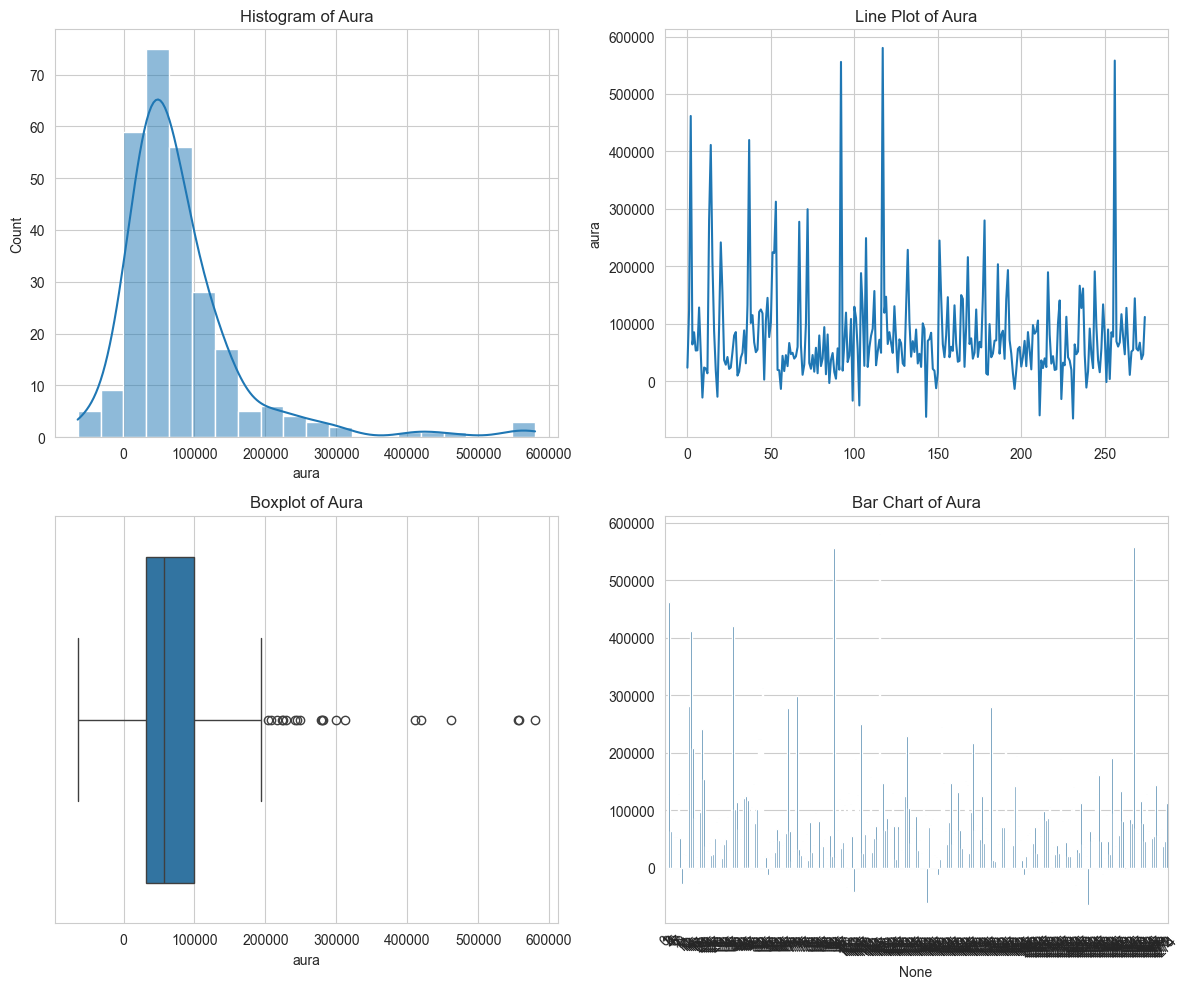

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming user_stats_df['aura'] is already available in the user's environment
aura_data = user_stats_df['aura']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(aura_data, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=aura_data, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=aura_data, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if aura_data.dtype == 'object':
    sns.countplot(y=aura_data, ax=axes[1, 1])
else:
    sns.barplot(x=aura_data.index, y=aura_data.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [30]:
user_stats_df[['user', 'aura']].sort_values(by='aura').tail(50)

,user,aura
173,haHAA_12_btw,125017.0
44,HansoloSupremo,125077.0
131,catsspurr,125221.0
105,Wii_Gii,125745.0
236,shenxir,127641.0
263,xan_gny,127840.0
7,55Dash,128486.0
100,Vidke04,129770.5
124,blind_dood,130687.0
160,finskbamse,132292.5


In [31]:
print(user_stats_df[['user', 'bit']].sort_values(by='bit').tail(10))

                         user   bit
249              thebigdogjay   225
141                   damm1jp   425
237                  shogalul   450
3                    1SKELTON  1275
236                   shenxir  1275
14   Aluminiumminimumimmunity  1725
256                   uuccugr  1950
219                 rebbel576  2325
100                   Vidke04  2375
20                CrazeE420xd  2975


In [32]:
print(user_stats_df[['user', 'longest_streak']].sort_values(by='longest_streak').tail(50))

                         user  longest_streak
243              softarballtt              26
217                  pige0n98              27
139                cukululu41              27
21                    Cuhhsin              27
121                  bigabugj              27
268            ylb_cat_soul22              28
216                 phrank007              28
100                   Vidke04              29
167                giorgoslep              29
107                   Zeololz              30
128              cake_for_me_              30
131                 catsspurr              30
152                   emad_c7              32
241                smilodon_j              32
13                    Aloddin              33
137                 cringeuss              33
210                   paaaat_              34
115              astrologer95              35
104               Wanderer039              36
235          sercanwinchester              37
51                IvanOnMyOwn     

In [33]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_1'].unique()

# If you want to print them
print(unique_words)

['xqc32' 'the' 'ome44' 'is' 'you' 'speed1' 'FEET' 'FEIN' '1' 'NOWAYING'
 'ome99' 'omE' 'PepeLaugh' 'I' 'English' 'LUL' 'lul' 'druskiDance' 'a'
 'LOL' '!boost' 'i' 'loeyaKEKW' 'LULW' 'RaveTime' 'ReallyMad' 'Listening'
 'Smurfing' '@dorozea' '?' 'mhm' 'u' 'Banger' 'bye' 'OMEGALUL'
 'erbyMariodance' 'hi' 'lol' 'doro' 'ICANT' 'BangbooBounce' 'DORO' 'Yay'
 'PewPewPew' 'dorozeaTouchingyou' 'forsenLaughingAtYou' 'YEP' 'Clap'
 'ome808' 'STREAMER' 'DinoDance' 'PagChomp' 'xd' 'LETSGO' 'WW' 'forsenE'
 '!' 'dorozeaSlam' 'moustache' 'om' 'FROM' 'Joel' 'RalpherZ']


In [34]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_2'].unique()

# If you want to print them
print(unique_words)

['speed1' 'you' 'the' 'i' 'is' 'FEIN' '\U000e0000' 'u' 'FLASHBANG' 'ome32'
 'I' 'ome44' 'Tier' 'a' 'gg' 'LOL' 'DORO' 'Joel' 'bye' 'CaitThinking'
 'Only' 'LUL' 'Smurfing' 'nyanPls' 'OOOO' 'ratomilton' 'ICANT' 'omE' '?'
 'tuah!' 'DaRRa' 'catJAM' 'om' 'WatchingStream' '/' ':D' 'erbyLuigidance'
 'dorozeaSlam' 'GoldPLZ' '@Martin_Gales' 'yes' 'muted' 'dorozeaHey'
 'WideRaveTime' 'JinxLUL' 'it' 'TEAM' 'DinoDance' 'to' 'lol' 'ome96'
 'omEE' '!play' 'EZ' '😂😂😂' 'AlienPls3' 'Kappa' 'NO' '!boost' 'ome52'
 'FREE' 'doro' 'PepeLaugh' 'nt' 'WW' 'Banger' 'YEIN' 'ome5' 'RUSSIA' 'qq'
 'xan_gny' 'CHAT']


In [35]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_3'].unique()

# If you want to print them
print(unique_words)

['wideSpeedLaugh3' 'a' 'FEIN' 'you' 'hi' 'it' 'i' 'is' 'uuh' 'LOL' '16'
 'mhm' 'widetime' 'to' 'BANGER' 'buh' 'the' 'speed1' 'OOOO' 'ome44' 'LUL'
 'u' 'ome96' '?' '[warning]' 'AREYOUAGIRL' 'Cheer1000' 'xar2EDM'
 'arnoldHalt' 'qq' 'TEAM' 'o7' 'KEKW' '))' '\U000e0000' 'omE' 'yes'
 'PepeLaugh' 'PAUSENEMOGU' 'Who' 'Joel' 'DORO' 'I' '@Martin_Gales' 'xd'
 'andrea540Doof' 'dorozeaAlert' 'SeemsGood' 'gg' 'OMEGALUL' 'om' 'JARVIS'
 'BloodTrail' 'Banger' 'Doro' 'OMEYES' 'she' 'DarkKnight' 'ome32'
 'DinoDance' 'ome5' 'WAJAJA' '@dorozea' '!play' 'yo' 'mikuPls' 'Headbang'
 'your' 'fein' 'hiii' 'HIGHLIGHT' 'MEGALUL' 'RAID' 'FeelsWowMan' 'doro'
 'paaaat_' 'peepoDJ' 'She' 'jah' 'bro' 'on' 'Dorozea' 'IT'
 'dorozeaSignOff' 'ome99' 'WITH' 'Tier' 'NO']


In [36]:
user_stats_df[user_stats_df['user']=='balintboss']

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,longest_streak,first_message_date,first_message_text,last_message_date,last_message_text,cheer,warn_count,bit,gifts,aura
117,balintboss,28449,115885,4.07343,103.076087,the,2163,you,2091,is,...,277,2024-05-01 17:06:18+02:00,ready to 1984,2025-03-25 20:59:21+01:00,god speed,0,2,0,0.0,580133.0


In [37]:
user_stats_df[user_stats_df['user']=='Aluminiumminimumimmunity']

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,longest_streak,first_message_date,first_message_text,last_message_date,last_message_text,cheer,warn_count,bit,gifts,aura
14,Aluminiumminimumimmunity,8585,27370,3.188119,32.767176,FEIN,4647,ome44,3236,widetime,...,132,2024-05-12 01:04:40+02:00,lirikWavy,2025-03-25 20:59:08+01:00,bye bye,16773,11,1725,46.0,411319.0


In [38]:
user_stats_df[user_stats_df['user']=='Aluminiumminimumimmunity']


,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,longest_streak,first_message_date,first_message_text,last_message_date,last_message_text,cheer,warn_count,bit,gifts,aura
14,Aluminiumminimumimmunity,8585,27370,3.188119,32.767176,FEIN,4647,ome44,3236,widetime,...,132,2024-05-12 01:04:40+02:00,lirikWavy,2025-03-25 20:59:08+01:00,bye bye,16773,11,1725,46.0,411319.0


In [39]:
user_stats_df.nlargest(10, 'word_per_message')

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,longest_streak,first_message_date,first_message_text,last_message_date,last_message_text,cheer,warn_count,bit,gifts,aura
99,Typhu25,17176,287488,16.737774,83.785366,FEIN,136660,ome44,50397,speed1,...,25,2024-05-06 22:30:07+02:00,!play,2025-03-25 20:14:35+01:00,nah he just bought it Clueless,400,1,0,0.0,-33630.0
92,StreamElements,26648,358231,13.443073,96.550725,the,18463,/,15795,to,...,277,2024-05-01 17:04:08+02:00,dorozea is now live! Streaming Just Chatting: ...,2025-03-25 20:57:08+01:00,"Dorozea is 22 years old, born in 2002.",0,0,0,0.0,555806.0
9,ACEiCLE,675,6939,10.280000,135.000000,speed1,5998,󠀀,258,uuh,...,2,2025-01-31 16:58:50+01:00,LOL,2025-03-20 22:01:10+01:00,!bedrooms,0,0,0,0.0,-28222.0
15,AnAnonymousGifter,979,9792,10.002043,15.296875,1,983,Tier,979,to,...,7,2024-05-16 19:57:51+02:00,An anonymous user gifted a Tier 1 sub to asd_u...,2025-03-23 16:12:20+01:00,An anonymous user gifted a Tier 3 sub to yddre...,0,0,0,1351.0,207579.0
215,peroni_nasturo_azuro,1735,15745,9.074928,25.895522,a,569,you,496,the,...,7,2024-05-01 21:36:02+02:00,roadhog is a british football fan he loves peroni,2024-10-20 19:04:01+02:00,@1206paul_ i refreshed and the code isnt in ch...,0,0,0,0.0,24859.0
37,Fossabot,5209,47036,9.029756,25.787129,English,4934,Only,4934,[warning],...,202,2024-07-26 15:04:33+02:00,"@BERAT612850, Blocked language detected [warning]",2025-03-25 20:58:29+01:00,"@neat_beout3, English Only In Chat so mods can...",0,0,0,0.0,419905.0
174,hanepirukas1,1216,10661,8.767270,33.777778,YEP,273,is,258,the,...,5,2024-05-07 21:07:12+02:00,"Dogs sniff eachothers ass, what would human eq...",2024-10-03 17:35:58+02:00,(fart),300,0,0,0.0,42435.0
129,captainmark2024,758,6476,8.543536,42.111111,the,168,you,142,is,...,12,2025-02-21 17:36:22+01:00,"Hello dorozea, my best friend ever",2025-03-15 16:40:06+01:00,trump: Doro must play for 10K in CS or it will...,0,0,0,0.0,31158.0
239,sisq,760,6466,8.507895,63.333333,Smurfing,3799,speed1,752,IT,...,3,2024-10-19 16:13:35+02:00,cona,2025-03-25 18:41:12+01:00,WW,0,0,0,0.0,-10842.0
159,fcukboii,934,7481,8.009636,21.227273,PewPewPew,464,DinoDance,393,DarkKnight,...,9,2024-11-07 14:30:03+01:00,How old are you?!,2025-03-25 17:41:53+01:00,DarkKnight DarkKnight DinoDance PewPewPew,0,2,0,0.0,53022.0


In [40]:
user_stats_df.nlargest(10, 'total_streams')

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,longest_streak,first_message_date,first_message_text,last_message_date,last_message_text,cheer,warn_count,bit,gifts,aura
92,StreamElements,26648,358231,13.443073,96.550725,the,18463,/,15795,to,...,277,2024-05-01 17:04:08+02:00,dorozea is now live! Streaming Just Chatting: ...,2025-03-25 20:57:08+01:00,"Dorozea is 22 years old, born in 2002.",0,0,0,0.0,555806.0
117,balintboss,28449,115885,4.073430,103.076087,the,2163,you,2091,is,...,277,2024-05-01 17:06:18+02:00,ready to 1984,2025-03-25 20:59:21+01:00,god speed,0,2,0,0.0,580133.0
2,1206paul_,20829,110663,5.312929,78.011236,ome44,3979,the,2615,FEIN,...,168,2024-05-01 17:12:43+02:00,go and find some friends ICANT,2025-03-24 18:24:49+01:00,so this guy had sex with a horse?,200,0,0,1.0,461730.0
14,Aluminiumminimumimmunity,8585,27370,3.188119,32.767176,FEIN,4647,ome44,3236,widetime,...,132,2024-05-12 01:04:40+02:00,lirikWavy,2025-03-25 20:59:08+01:00,bye bye,16773,11,1725,46.0,411319.0
118,banties_x,29556,120412,4.074029,117.752988,speed1,8124,FEIN,7147,ome44,...,57,2024-05-01 17:04:28+02:00,Yooo,2025-03-25 20:22:38+01:00,is he??,10,0,0,1.0,119351.0
67,Martin_Gales,41510,246074,5.928066,169.428571,FEIN,17658,ome44,7049,the,...,52,2024-05-01 17:04:02+02:00,hi there,2025-03-24 20:10:20+01:00,better than the other porsche,526,0,0,0.0,277649.0
13,Aloddin,5938,34454,5.802290,24.436214,FEET,1082,I,1012,mhm,...,33,2024-05-01 17:04:22+02:00,yup,2025-03-25 16:53:28+01:00,yo,10,0,0,0.0,280931.0
72,Nightbot,2088,14064,6.735632,8.736402,is,696,tuah!,426,Who,...,58,2024-05-01 17:05:49+02:00,Submit your setups in the #rate-my-setup text ...,2025-03-25 20:24:33+01:00,check the qna for specs -> https://youtu.be/bK...,0,0,0,0.0,299490.0
191,klimzaa,19104,119284,6.243928,83.060870,ome44,12245,ome52,8111,fein,...,21,2024-05-01 17:38:07+02:00,!video,2025-03-25 20:58:57+01:00,WW stream,0,0,0,0.0,142763.0
107,Zeololz,4297,19392,4.512916,19.893519,u,470,i,392,the,...,30,2024-05-01 20:04:48+02:00,fuck valorant Smile,2025-03-25 18:46:54+01:00,i died,0,3,0,0.0,249235.0


In [41]:
user_stats_df['total_streams'].describe()

count    275.000000
mean      64.920000
std       55.736877
min        3.000000
25%       26.500000
50%       49.000000
75%       83.500000
max      276.000000
Name: total_streams, dtype: float64

In [42]:
user_stats_df.sort_values(by='last_message_date').head(25)

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,longest_streak,first_message_date,first_message_text,last_message_date,last_message_text,cheer,warn_count,bit,gifts,aura
206,nevadasieera,519,2234,4.304432,47.181818,the,44,to,42,FeelsWowMan,...,9,2024-05-15 17:59:05+02:00,why she so cute chat?,2024-06-11 14:27:10+02:00,i called her friend and now she thinks she's n...,0,0,0,0.0,20819.0
195,lothric_tenz,580,3365,5.801724,82.857143,the,142,you,89,to,...,5,2024-05-27 18:47:52+02:00,Hello! Is this your 1st Souls game ?,2024-06-17 19:58:58+02:00,"No worries, you will figure out a strat to bea...",0,0,0,10.0,13624.0
265,xxxflower1,791,2945,3.723135,79.100000,?,62,the,56,you,...,4,2024-06-09 16:33:24+02:00,first try btw,2024-06-24 14:30:32+02:00,alright,0,0,0,0.0,11241.0
83,RealDrLing,661,2509,3.795764,73.444444,the,81,LUL,64,to,...,2,2024-05-05 18:39:44+02:00,RealDrLing subscribed at Tier 1. They've subsc...,2024-06-24 21:14:23+02:00,bye,0,0,0,10.0,12305.0
128,cake_for_me_,606,784,1.293729,16.833333,lol,52,yes,41,gg,...,30,2024-05-20 17:54:41+02:00,rainbow 6 siege is like 21.05 eur,2024-07-13 19:08:40+02:00,hi,0,0,0,0.0,66558.0
84,Risc__V,2908,10524,3.618982,48.466667,the,228,is,184,you,...,18,2024-05-01 18:35:36+02:00,DIESOFCRINGE,2024-07-24 18:24:00+02:00,CLOWNDETECTED,0,0,0,0.0,81546.0
91,SercanLeaxl,687,1578,2.296943,68.700000,the,58,WatchingStream,47,LOL,...,10,2024-07-22 16:31:22+02:00,can u open the door,2024-08-01 15:48:36+02:00,#ad,0,1,0,0.0,20295.0
177,icep1cke,1389,2282,1.642909,17.362500,Clap,295,EZ,120,!play,...,65,2024-05-09 18:06:20+02:00,peepoClap,2024-08-09 20:48:43+02:00,!play 󠀀,100,0,0,10.0,147843.0
229,saadr223,678,3342,4.929204,23.379310,you,123,the,109,bro,...,6,2024-06-14 15:55:15+02:00,scripted game,2024-08-22 14:55:02+02:00,bro we use water,0,0,0,0.0,36074.0
97,TriplesingleJ,706,2751,3.896601,20.171429,is,107,you,77,to,...,9,2024-06-16 17:47:05+02:00,lol,2024-08-27 19:10:21+02:00,bye,0,0,0,0.0,44656.0


In [43]:
user_stats_df['buster_usage'].describe()

count    275.000000
mean       0.501818
std        1.707379
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       15.000000
Name: buster_usage, dtype: float64

In [44]:
user_stats_df[['user', 'cheer']].sort_values(by='cheer').tail(50)

,user,cheer
93,StunnerGR,0
4,1o1m4n,0
94,TandeBoy,0
62,Leftybrasco,10
26,Dmoz1,10
34,Eyght,10
13,Aloddin,10
185,kecso1g,10
118,banties_x,10
237,shogalul,10


In [45]:
user_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype                        
---  ------                    --------------  -----                        
 0   user                      275 non-null    object                       
 1   total_messages            275 non-null    int64                        
 2   total_words               275 non-null    int64                        
 3   word_per_message          275 non-null    float64                      
 4   avg_message_per_stream    275 non-null    float64                      
 5   most_common_word_1        275 non-null    object                       
 6   most_common_word_1_count  275 non-null    int64                        
 7   most_common_word_2        275 non-null    object                       
 8   most_common_word_2_count  275 non-null    int64                        
 9   most_common_word_3        275 non-null    o

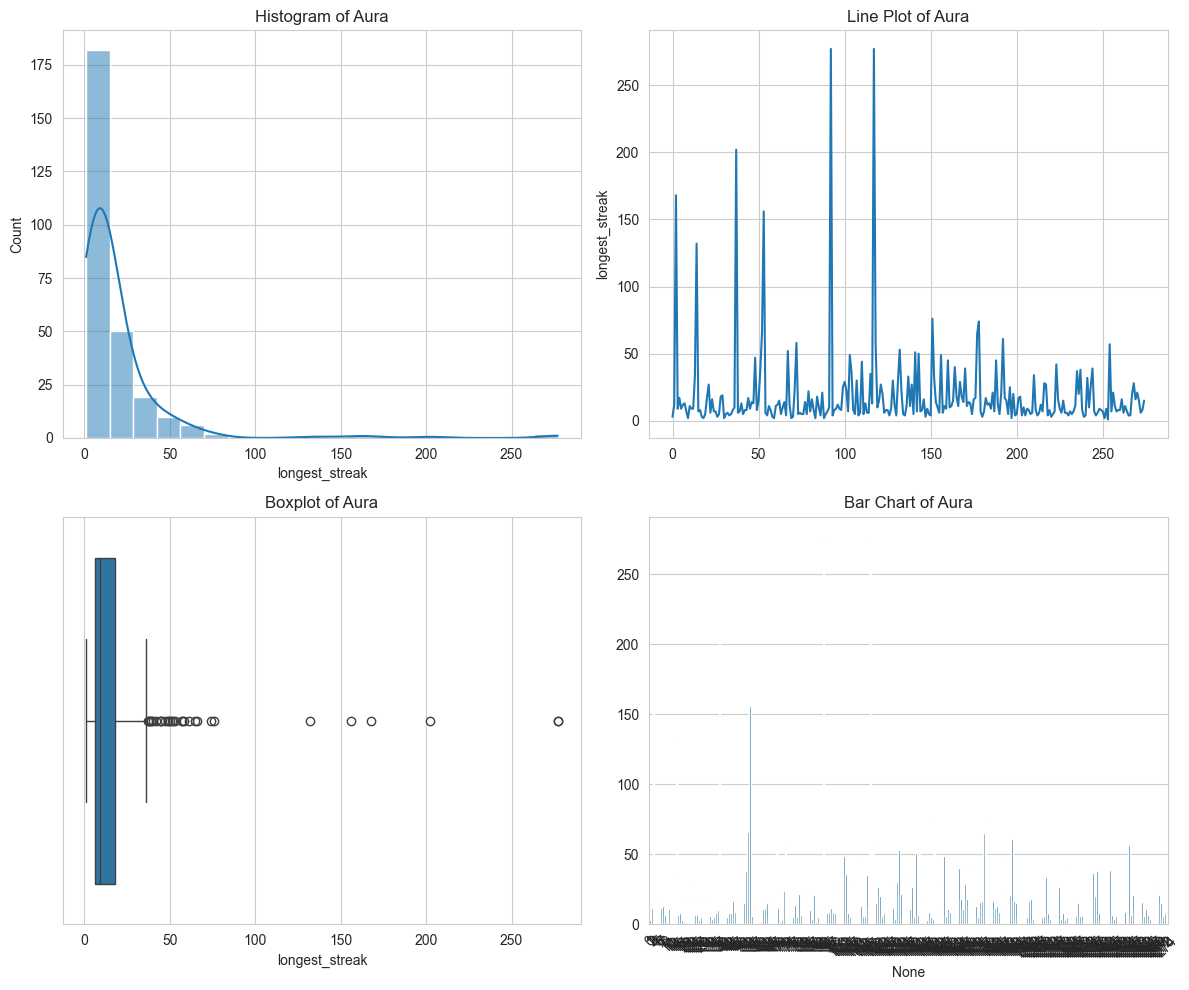

In [46]:

# Assuming user_stats_df['aura'] is already available in the user's environment
longest_streak_data = user_stats_df['longest_streak']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(longest_streak_data, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=longest_streak_data, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=longest_streak_data, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if longest_streak_data.dtype == 'object':
    sns.countplot(y=longest_streak_data, ax=axes[1, 1])
else:
    sns.barplot(x=longest_streak_data.index, y=longest_streak_data.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


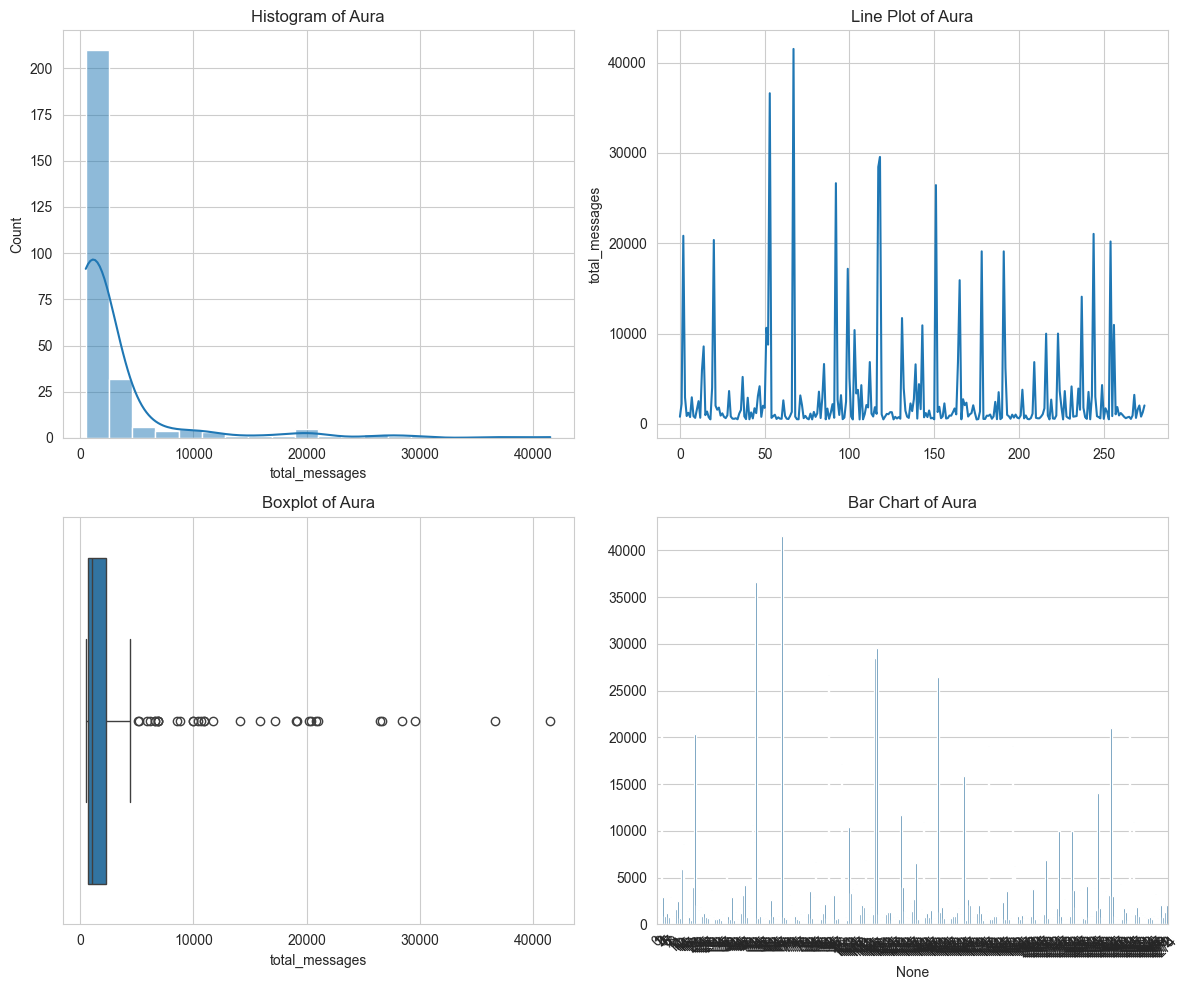

In [52]:

# Assuming user_stats_df['aura'] is already available in the user's environment
total_streams = user_stats_df['total_messages']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(total_streams, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=total_streams, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=total_streams, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if total_streams.dtype == 'object':
    sns.countplot(y=total_streams, ax=axes[1, 1])
else:
    sns.barplot(x=total_streams.index, y=total_streams.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [53]:
user_stats_df[['user', 'total_messages']].sort_values(by='total_messages').tail(50)

,user,total_messages
104,Wanderer039,3374
188,kindheadbanger,3522
241,smilodon_j,3551
82,Ravenbtw,3578
227,roxa0,3642
29,Drizzie3S,3646
224,rodrigo_20771,3667
105,Wii_Gii,3775
202,moondog357,3790
235,sercanwinchester,3920


In [51]:
user_stats_df['total_messages'].describe()

count      275.000000
mean      3003.556364
std       5668.413689
min        500.000000
25%        676.500000
50%       1038.000000
75%       2316.500000
max      41510.000000
Name: total_messages, dtype: float64